# Purpose of this project
Predicting the stock price moves (up or down) in a day from a set of news titles. For more detail, please see the presentation file in ppt.

In [1]:
import string
import pandas as pd
import numpy as np
import datetime 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from wordcloud import WordCloud
import seaborn as sns
import time

In [2]:
SP_df = pd.read_csv("WIKI_PRICES.csv")

In [3]:
SP_df.head()

,ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
0,A,1999-11-18,45.50,50.00,40.00,44.00,44739900.0,0.0,1.0,31.105117,34.181447,27.345157,30.079673,44739900.0
1,A,1999-11-19,42.94,43.00,39.81,40.38,10897100.0,0.0,1.0,29.355027,29.396044,27.215268,27.604936,10897100.0
2,A,1999-11-22,41.31,44.00,40.06,44.00,4705200.0,0.0,1.0,28.240711,30.079673,27.386175,30.079673,4705200.0
3,A,1999-11-23,42.50,43.63,40.25,40.25,4274400.0,0.0,1.0,29.054230,29.826730,27.516065,27.516065,4274400.0
4,A,1999-11-24,40.13,41.94,40.00,41.06,3464400.0,0.0,1.0,27.434029,28.671398,27.345157,28.069804,3464400.0


In [4]:
NEWS_df = pd.read_csv("uci-news-aggregator.csv")

In [5]:
NEWS_df = NEWS_df[NEWS_df['CATEGORY']=='b']
NEWS_df.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [6]:
new_ticker1_df = pd.read_csv("companylist.csv")
new_ticker2_df = pd.read_csv("companylistNYSE.csv")
new_ticker_df = pd.concat([new_ticker1_df, new_ticker2_df])

In [7]:
new_ticker_df.head()
#len(new_ticker_df)

,Symbol,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,Unnamed: 9
0,PIH,"1347 Property Insurance Holdings, Inc.",7.825,4.661169e+07,n/a,2014,Finance,Property-Casualty Insurers,http://www.nasdaq.com/symbol/pih,NaN
1,TURN,180 Degree Capital Corp.,1.6,4.979450e+07,n/a,n/a,Finance,Finance/Investors Services,http://www.nasdaq.com/symbol/turn,NaN
2,FLWS,"1-800 FLOWERS.COM, Inc.",9.65,6.304837e+08,n/a,1999,Consumer Services,Other Specialty Stores,http://www.nasdaq.com/symbol/flws,NaN
3,FCCY,1st Constitution Bancorp (NJ),17.25,1.384716e+08,n/a,n/a,Finance,Savings Institutions,http://www.nasdaq.com/symbol/fccy,NaN
4,SRCE,1st Source Corporation,48.67,1.261704e+09,n/a,n/a,Finance,Major Banks,http://www.nasdaq.com/symbol/srce,NaN


create a dictionary which includes the companis' name and ticker

In [8]:
companies = {}
for ind, row in new_ticker_df.iterrows():
    if (len(row['Name']) > 1) & (len(row['Symbol']) > 1): 
        companies[row['Name']] = row['Symbol']

make the company names more detectable

In [9]:
remove_list = ['inc', 'plc', 'ltd', 'corporation', 'corp', 'incorporated', 'limited']
translator = str.maketrans('', '', string.punctuation)
filtered_companies = {}
for name, ticker in companies.items():
    lowercase_name = name.lower()
    lowercase_name = lowercase_name.translate(translator)
    for word in remove_list:
        lowercase_name = lowercase_name.replace(word, "")
        
    lowercase_name = lowercase_name.rstrip()
    filtered_companies[lowercase_name] = ticker

Create a function that check whether the news title includes any company, and then create a new column that have a ticker corresponding each news

In [10]:
def company_in_news(paragraph, companies):
    """
    input; paragraph: string, companies: dictionary
    output; boolean
    """

    is_inNews = False
    for name, ticker in companies.items():
        if ' ' + name + ' ' in paragraph or ' ' + ticker + ' ' in paragraph:
            return ticker
    
    return np.nan

start = time.time()
NEWS_df['ticker'] = NEWS_df['TITLE'].apply(company_in_news, args=(filtered_companies,))
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
NEWS_companies_df = NEWS_df.dropna(how='any')

elapsed_time:332.7424819469452[sec]


In [11]:
NEWS_companies_df.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,ticker
9,10,ECB unlikely to end sterilisation of SMP purch...,http://www.iii.co.uk/news-opinion/reuters/news...,Interactive Investor,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,www.iii.co.uk,1394470501265,SMP
10,11,ECB unlikely to end sterilization of SMP purch...,http://in.reuters.com/article/2014/03/10/us-ec...,Reuters India,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,1394470501410,SMP
22,23,Bad loan triggers key feature in ECB bank test...,http://www.globalpost.com/dispatch/news/thomso...,GlobalPost,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,www.globalpost.com,1394470503726,KEY^I
29,30,REFILE-Bad loan triggers key feature in ECB ba...,http://in.reuters.com/article/2014/03/10/euroz...,Reuters,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,1394470505070,KEY^I
61,62,EBay Asks Shareholders To Vote Against PayPal ...,http://techcrunch.com/2014/03/10/ebay-asks-sha...,TechCrunch,b,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,techcrunch.com,1394470922918,CEO


some preparation for next function

In [12]:
# make timestamp to datetime
NEWS_companies_df['TIMESTAMP'] = pd.to_datetime(NEWS_companies_df['TIMESTAMP'], unit='ms')

# create a list that store the dates in order
date_set = set(SP_df['date'])
date_list = list(date_set)
date_list.sort()

# create a dictionary that gives the adj_close price corresponding date and ticker
combi = {}
for date, ticker, close in zip(SP_df['date'], SP_df['ticker'], SP_df['adj_close']):
    combi[(date, ticker)] = close

C:\Users\the_b\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


create a function that takes the corresponding stock price move, and apply it to the data

In [13]:
def get_move(row):
    
    """
    input; row: entire row, SP_df: DataFrame of stock price
    output; boolean
    """    
    
    date_tmp = row['TIMESTAMP']
    
    #check the hour of the news, and then if it's after 17, make the date next day.
    if date_tmp.hour >= 17:
        date = date_tmp + datetime.timedelta(days=1)
    else:
        date = date_tmp
    date1 = datetime.datetime.strftime(date, "%Y-%m-%d")

    
    try:
        ind = date_list.index(date1)
    except ValueError:
        return np.nan
    date0 = date_list[ind-1]

    
    try:
        day0_price = combi[(date0, row['ticker'])]
        day1_price = combi[(date1, row['ticker'])]
    except KeyError:
        return np.nan
    
    #return True if the stock price went up 
    if ((day1_price - day0_price)/day0_price) > 0:
        return True
    else:
        return False
    
    
NEWS_companies_df['IsUp'] = NEWS_companies_df.apply(get_move, axis = 1)

C:\Users\the_b\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
NEWS_companies_df.sample(10)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,ticker,IsUp
146440,146776,Netflix Set To Raise Prices After Good First Q...,http://www.hngn.com/articles/29377/20140422/ne...,Headlines \& Global News,b,dWkQWEysS02q0rMo7WrWg28bqNrcM,www.hngn.com,2014-04-22 09:44:39.219,DVD,NaN
76498,76574,Japan raises sales tax for first time in 17 ye...,http://www.euronews.com/2014/04/01/japan-raise...,euronews,b,d6xEaa9_ah4yprMGV9Qc_K_iJ8zjM,www.euronews.com,2014-04-01 15:29:00.500,TIME,NaN
272541,272987,Tesla Motors' (TSLA) CEO Elon Musk Hosts 2014 ...,http://seekingalpha.com/article/2251683-tesla-...,Seeking Alpha,b,dENUOKJciS7TC6Ml-DZqMjtX7vZnM,seekingalpha.com,2014-06-04 13:19:40.887,CEO,NaN
180207,180543,U.S. to unleash IRS on Russia,http://www.news-journal.com/news/world/u-s-to-...,Longview News-Journal,b,dLwL4PxXW3qwcxMjJMuCMRFIX1HIM,www.news-journal.com,2014-05-06 09:52:01.208,IRS,NaN
132232,132568,Ex-BP employee charged over BP stock sales aft...,https://au.finance.yahoo.com/news/ex-bp-employ...,Yahoo\!7 News,b,dZbQKJkqNGds8RMs5-0ml2LslPoXM,au.finance.yahoo.com,2014-04-18 13:18:04.097,BP,NaN
180658,180994,Deaths Rates Fell in MA After Health-Care Reform,http://www.webmd.com/health-insurance/20140505...,WebMD,b,dmWKwgJbLUIbvLMjROokOrvyK0HQM,www.webmd.com,2014-05-06 10:34:52.384,MA,False
76766,76842,Facebook CEO reaps $3.3 billion gain from stoc...,http://www.thonline.com/biztimes/articles/arti...,Dubuque Telegraph Herald,b,dJt2-HUDZFYvNEMd6fEtIdPVJdgSM,www.thonline.com,2014-04-01 15:58:47.978,CEO,NaN
8942,8943,LULAC Welcomes FTC Probe into Herbalife's Dece...,http://www.indybay.org/newsitems/2014/03/12/18...,Bay Area Indymedia,b,dey1wWSDFLloFaMb4H5WhUu2P5biM,www.indybay.org,2014-03-13 11:35:01.231,FTC,NaN
152186,152522,Valeant CEO 'Disappointed' In Allergan Poison ...,http://www.moneynews.com/streettalk/valeant-ce...,Moneynews,b,dOlCDTpbRrXmCNMAaajueJz4pmidM,www.moneynews.com,2014-04-23 17:16:47.871,CEO,NaN
180404,180740,"Australian Awaits RBA Decision, Westpac Net Ri...",http://www.123jump.com/market-update/Australia...,123Jump.com,b,dUIywf780__6guMrAZO3IzHLcxDUM,www.123jump.com,2014-05-06 10:00:21.017,RBA,NaN


remove company names from news titles because company name itself should not have any impact on stock price move  
Also remove rows that doesn't have stock price move

In [15]:
def remove_names(paragraph, companies):
    """
    input; paragraph: string, companies: dictionary
    output; name: company's ticker
    """
    words = paragraph.split()
    for i in range(len(words)):
        if words[i] in companies.keys() or words[i] in companies.items():
            return paragraph.replace(words[i], "")
    
    return paragraph

NEWS_companies_df['TITLE'] = NEWS_companies_df['TITLE'].apply(remove_names, args=(filtered_companies,))
with_move_df = NEWS_companies_df.dropna(how='any')

C:\Users\the_b\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


check the number of True and False

In [16]:
unique, counts = np.unique(with_move_df['IsUp'].values, return_counts=True)
dict(zip(unique, counts))

{False: 842, True: 731}

to avoid duplicate of the news, aggregate news titles from same day

In [17]:
# truncate the time in the day
def add_time(row):
    return datetime.datetime.strftime(row['TIMESTAMP'], "%Y-%m-%d")

In [18]:
with_move_df['Day'] = with_move_df.apply(add_time, axis = 1)


C:\Users\the_b\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
grouped = with_move_df.groupby(['Day','ticker'])


create functions that give the aggregated title for a day and Isup

In [20]:
def concat(series):
    all_titles = ''
    for title in series:
            all_titles += '' + title
    return all_titles

def concat2(series):
    return series.sample(1)

vectorise the texts and build the linear SVC model

In [21]:
count_vectorizer = CountVectorizer()
X = count_vectorizer.fit_transform(grouped.agg({'TITLE': concat}).TITLE)
y = grouped.agg({'IsUp': concat2})
y = y.IsUp.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

parameters = {'C':[1, 10, 100, 1000]}
svr = LinearSVC(random_state=0)
clf = GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print(confusion_matrix(y_test, predicted))
print(classification_report(y_test,
                            predicted,
                            target_names=['up', 'down']))
print(classification_report(y_train,
                            clf.predict(X_train),
                            target_names=['up', 'down']))
print(accuracy_score(y_test, predicted))

[[31 26]
 [38 22]]
             precision    recall  f1-score   support

         up       0.45      0.54      0.49        57
       down       0.46      0.37      0.41        60

avg / total       0.45      0.45      0.45       117

             precision    recall  f1-score   support

         up       1.00      1.00      1.00       217
       down       1.00      1.00      1.00       248

avg / total       1.00      1.00      1.00       465

0.452991452991


In [22]:
clf.best_params_

{'C': 10}

Build the LogisiticRegression model

In [23]:
parameters = {'C':[1, 10, 100, 1000]}
LR = LogisticRegression()
clf2 = GridSearchCV(LR, parameters)
clf2.fit(X_train, y_train)
predicted2 = clf2.predict(X_test)
print(confusion_matrix(y_test, predicted2))
print(classification_report(y_test,
                            predicted2,
                            target_names=['up', 'down']))
print(classification_report(y_train,
                            clf2.predict(X_train),
                            target_names=['up', 'down']))
print(accuracy_score(y_test, predicted2))

[[30 27]
 [35 25]]
             precision    recall  f1-score   support

         up       0.46      0.53      0.49        57
       down       0.48      0.42      0.45        60

avg / total       0.47      0.47      0.47       117

             precision    recall  f1-score   support

         up       1.00      1.00      1.00       217
       down       1.00      1.00      1.00       248

avg / total       1.00      1.00      1.00       465

0.470085470085


In [24]:
clf2.best_params_

{'C': 1}

Create wordclouds based on the weights of coefficients

In [25]:
positive = ''
negative = ''
for word, coef in zip(count_vectorizer.get_feature_names(), clf.best_estimator_.coef_[0]):
    
    if coef >= 0:
        for i in range(round(float('{0:02f}'.format(coef*100)))):
            positive += ' ' + '{0}'.format(word)
    else:
        for i in range(-round(float('{0:02f}'.format(coef*100)))):
            negative += ' ' + '{0}'.format(word)

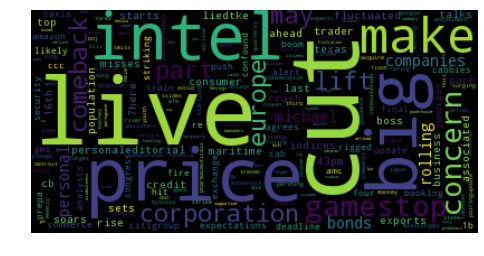

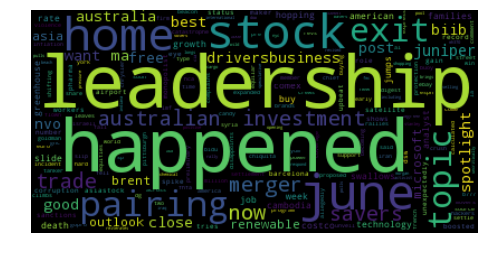

In [26]:
wordcloud = WordCloud(collocations=False).generate(positive)
wordcloud2 = WordCloud(collocations=False).generate(negative)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.figure()
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.show()

use seaborn to visualize the data

extract frequent words for both news going up and down

In [27]:
def take_important(df, IsTrue):
    new_df = df['TITLE'][df['IsUp']==IsTrue]
    counter = Counter()
    for index, row in new_df.iteritems():
        counter += Counter(row.split())

    return counter

count_up = take_important(with_move_df, True)
count_down = take_important(with_move_df, False)

remove stopwords from the lists

In [28]:
with open('stopwords.txt') as f:
    stop_words = []
    for line in f:
        stop_words.append(line.rstrip())

In [29]:
def eliminate_stop_words(counter):
    dummy = counter.copy()
    punc = set(string.punctuation)
    punc.update(['...', '–'])
    for key, num in dummy.items():
        if key.lower() in stop_words or key in punc:
            counter.pop(key)
    
    return counter

In [30]:
count_up = eliminate_stop_words(count_up)
count_down = eliminate_stop_words(count_down)

create a table that includes frequent words, and then visualize it using seaborn

In [31]:
def create_freq_table(counter, num):
    """
    counter: counter object
    num: int, which specify how many most common words it is needed to return
    return: DataFrame
    """
    counter2 = counter.most_common(num)
    counter2 = sorted(counter2, key=lambda tup: tup[1], reverse=True)
    
    words_freqs_up = {'words': [tup[0] for tup in counter2],
                      'freqs': [tup[1] for tup in counter2]}
    words_freqs_df = pd.DataFrame(words_freqs_up)
    
    return words_freqs_df

In [32]:
words_freqs_up_df = create_freq_table(count_up, 10)
words_freqs_down_df = create_freq_table(count_down, 10)

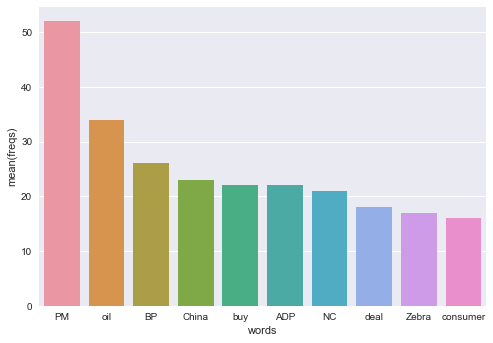

In [33]:
my_plot = sns.barplot(x='words', y='freqs', data=words_freqs_up_df)
#my_plot.get_figure().savefig('freq_up.png', dpi=200)
sns.plt.show()

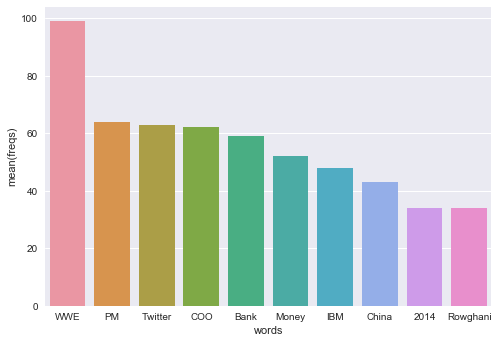

In [34]:
my_plot2 = sns.barplot(x='words', y='freqs', data=words_freqs_down_df)
#my_plot2.get_figure().savefig('freq_down.png', dpi=200)
sns.plt.show()

next, try to extract frequent words that are exclusive each other

In [35]:
words_freqs_up_df = create_freq_table(count_up, 20)
words_freqs_down_df = create_freq_table(count_down, 100)

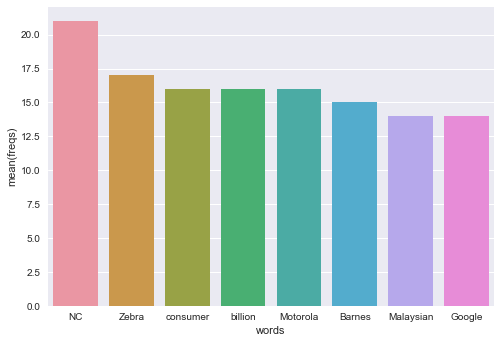

In [36]:
down_set = set(words_freqs_down_df.words)
words_freqs_up_df = words_freqs_up_df[words_freqs_up_df.apply(lambda row: row['words'] not in down_set, axis=1)]
my_plot = sns.barplot(x='words', y='freqs', data=words_freqs_up_df)
#my_plot.get_figure().savefig('freq_up.png', dpi=200)
sns.plt.show()

In [37]:
words_freqs_up_df = create_freq_table(count_up, 100)
words_freqs_down_df = create_freq_table(count_down, 20)

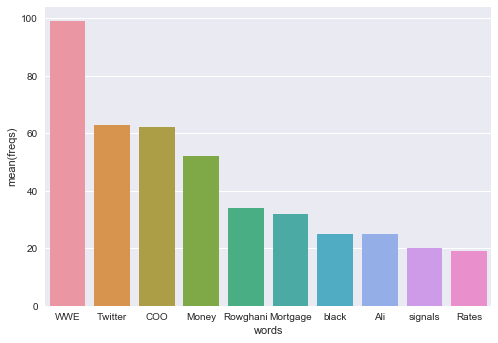

In [38]:
up_set = set(words_freqs_up_df.words)
words_freqs_down_df = words_freqs_down_df[words_freqs_down_df.apply(lambda row: row['words'] not in up_set, axis=1)]
my_plot = sns.barplot(x='words', y='freqs', data=words_freqs_down_df)
#my_plot.get_figure().savefig('freq_up.png', dpi=200)
sns.plt.show()

Future task
1. more data  
2. market expectation  
3. context  
4. publishers
5. Exclude other factors